# UFO Sightings: NLP and Time-Series Modeling
# Rahul Rajeev

**Goals**
1. Frequency of visits centered around location, time of day, month of year?
2. Most common descriptions of UFO vehicles using bag of words processing
3. Time-series modeling to check whether visits are seasonal or not

In [282]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import nltk
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from random import randint
import plotly.express as px
from datetime import datetime
import regex as re
from wordcloud import WordCloud
from pickle import dump
from keras.models import load_model
from pickle import load
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# modeling libraries and functions
from keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

In [580]:
# load ufo csv
ufo_df = pd.read_csv('ufo.csv').drop('Unnamed: 0', axis=1)
ufo_df.head()

Date_time date_documented  Year  Month  Hour  Season  \
0  1949-10-10 20:30:00       4/27/2004  1949     10    20  Autumn   
1  1949-10-10 21:00:00      12/16/2005  1949     10    21  Autumn   
2  1955-10-10 17:00:00       1/21/2008  1955     10    17  Autumn   
3  1956-10-10 21:00:00       1/17/2004  1956     10    21  Autumn   
4  1960-10-10 20:00:00       1/22/2004  1960     10    20  Autumn   

  Country_Code         Country   Region        Locale   latitude   longitude  \
0          USA   United States    Texas    San Marcos  29.883056  -97.941111   
1          USA   United States    Texas  Bexar County  29.384210  -98.581082   
2          GBR  United Kingdom  England       Chester  53.200000   -2.916667   
3          USA   United States    Texas          Edna  28.978333  -96.645833   
4          USA   United States   Hawaii       Kaneohe  21.418056 -157.803611   

  UFO_shape  length_of_encounter_seconds Encounter_Duration  \
0  Cylinder                       2700.0         45 minutes   
1     Light                       7200.0            1-2 hrs   
2    Circle                         20.0         20 seconds   
3    Circle                         20.0           1/2 hour   
4     Light                        900.0         15 minutes   

                                         Description  
0  This event took place in early fall around 194...  
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  
2  Green/Orange circular disc over Chester&#44 En...  
3  My older brother and twin sister were leaving ...  
4  AS a Marine 1st Lt. flying an FJ4B fighter/att...

In [4]:
print('Columns:', ufo_df.columns.to_list(), '\n\nShape:', ufo_df.shape)

Columns: ['Date_time', 'date_documented', 'Year', 'Month', 'Hour', 'Season', 'Country_Code', 'Country', 'Region', 'Locale', 'latitude', 'longitude', 'UFO_shape', 'length_of_encounter_seconds', 'Encounter_Duration', 'Description'] 

Shape: (80328, 16)


There are about 80328 documented UFO encounters in the dataset with 16 attributes as shown above. Since the date-time column covers the date_documented, year, month, and hour columns it's not really necessary to have the latter. But I will use for creating visualizations.

## 1. EDA and Visualizations

### Understanding the Composition

In [5]:
ufo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80328 entries, 0 to 80327
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date_time                    80328 non-null  object 
 1   date_documented              80328 non-null  object 
 2   Year                         80328 non-null  int64  
 3   Month                        80328 non-null  int64  
 4   Hour                         80328 non-null  int64  
 5   Season                       80328 non-null  object 
 6   Country_Code                 80069 non-null  object 
 7   Country                      80069 non-null  object 
 8   Region                       79762 non-null  object 
 9   Locale                       79871 non-null  object 
 10  latitude                     80328 non-null  float64
 11  longitude                    80328 non-null  float64
 12  UFO_shape                    78398 non-null  object 
 13  length_of_encoun

I am going to drop the date_documented column and the encounter_duration column because they are redundant.

In [3]:
ufo_df = ufo_df.drop(['date_documented','Encounter_Duration'], axis=1)

There are some null columns in the country_code, coutnry, region, locale, ufo_shape, and description channels. Luckily there aren't any missing in the date_time column to be used for the time-series modeling. However, something we should pay attention to is the appearance of special characters when not necessary in the description section. For example:

In [7]:
ufo_df['Description'][:10]

0    This event took place in early fall around 194...
1    1949 Lackland AFB&#44 TX.  Lights racing acros...
2    Green/Orange circular disc over Chester&#44 En...
3    My older brother and twin sister were leaving ...
4    AS a Marine 1st Lt. flying an FJ4B fighter/att...
5    My father is now 89 my brother 52 the girl wit...
6    penarth uk  circle  3mins  stayed 30ft above m...
7    A bright orange color changing to reddish colo...
8    Strobe Lighted disk shape object observed clos...
9    Saucer zaps energy from powerline as my pregna...
Name: Description, dtype: object

Some of the lines include a weird combination of &#44. I'm not sure if that was an error repeatedly occuring while the data was being collected but it will be something I will have to clean before working with the NLP.

### Visualizing

**1) Pie Chart of Visits per Season**

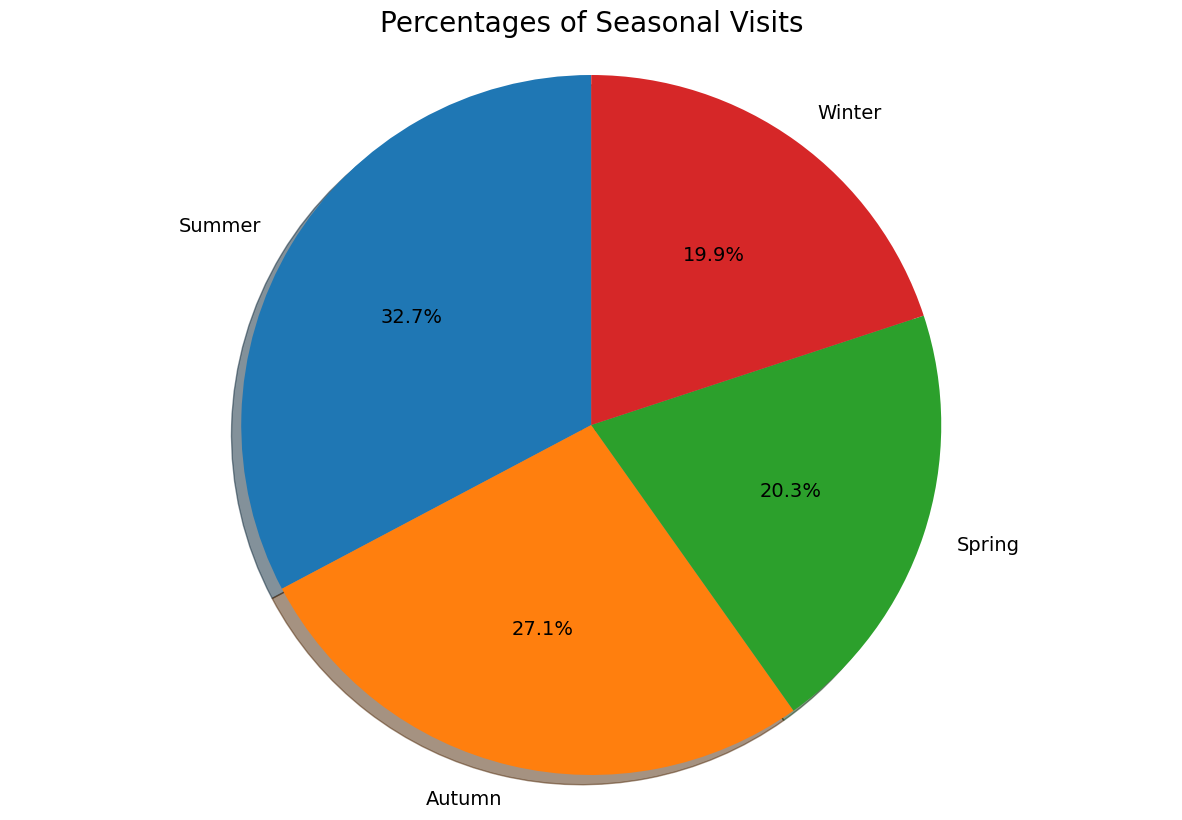

In [8]:
# pie chart visits per season

season_counts = ufo_df['Season'].value_counts().reset_index()
season_counts.columns = ['seasons','counts']


plt.figure(figsize=(15,10));
plt.pie(season_counts['counts'], labels =season_counts['seasons'], autopct='%1.1f%%', textprops={'fontsize': 14},
        shadow=True, startangle=90, )
plt.title('Percentages of Seasonal Visits', fontsize = 20)
plt.axis('equal')
plt.show()

**Summary:** Summer has about a third of the recorded encounters followed by autumn as close to a quarter and then spring and winter at about 1/5th.

**2) Choropleth map of sightings in the US**

In [581]:
us_state_to_abbrev = {"Alabama": "AL","Alaska": "AK","Arizona": "AZ","Arkansas": "AR","California": "CA","Colorado": "CO",
                      "Connecticut": "CT","Delaware": "DE","Florida": "FL", "Georgia": "GA","Hawaii": "HI",
                      "Idaho": "ID","Illinois": "IL","Indiana": "IN","Iowa": "IA","Kansas": "KS","Kentucky": "KY",
                      "Louisiana": "LA","Maine": "ME","Maryland": "MD","Massachusetts": "MA","Michigan": "MI","Minnesota": "MN",
                      "Mississippi": "MS","Missouri": "MO","Montana": "MT","Nebraska": "NE","Nevada": "NV","New Hampshire": "NH",
                      "New Jersey": "NJ","New Mexico": "NM","New York": "NY","North Carolina": "NC","North Dakota": "ND",
                      "Ohio": "OH","Oklahoma": "OK","Oregon": "OR","Pennsylvania": "PA","Rhode Island": "RI",
                      "South Carolina": "SC","South Dakota": "SD","Tennessee": "TN","Texas": "TX","Utah": "UT","Vermont": "VT",
                      "Virginia": "VA","Washington": "WA", "West Virginia": "WV","Wisconsin": "WI","Wyoming": "WY",
                      "District of Columbia": "DC","American Samoa": "AS","Guam": "GU","Northern Mariana Islands": "MP",
                      "Puerto Rico": "PR","United States Minor Outlying Islands": "UM", "U.S. Virgin Islands": "VI",
}

us_ufo = ufo_df[ufo_df['Country_Code'] == 'USA']['Region'].value_counts().reset_index()
us_ufo.columns = ['state','counts']
us_ufo2 = us_ufo.replace({"state": us_state_to_abbrev})
us_ufo2.head()

state  counts
0    CA    9625
1    WA    4270
2    FL    4200
3    TX    3684
4    NY    3235

In [582]:
fig = px.choropleth(us_ufo2, locations='state',
                    locationmode="USA-states", color='counts', scope="usa", 
                   title="Choropleth Map for UFO Sightings in the US")
fig.show()

**Summary:** Most of the recorded encounteres were found on the west coast with california and washington. There were also high counts towards texas and florida, but most of the midwest has low counts.

**3) Encounter Duration Distribution**

In [11]:
ufo_df['length_of_encounter_seconds'].describe()

count    8.032800e+04
mean     9.017336e+03
std      6.202322e+05
min      1.000000e-03
25%      3.000000e+01
50%      1.800000e+02
75%      6.000000e+02
max      9.783600e+07
Name: length_of_encounter_seconds, dtype: float64

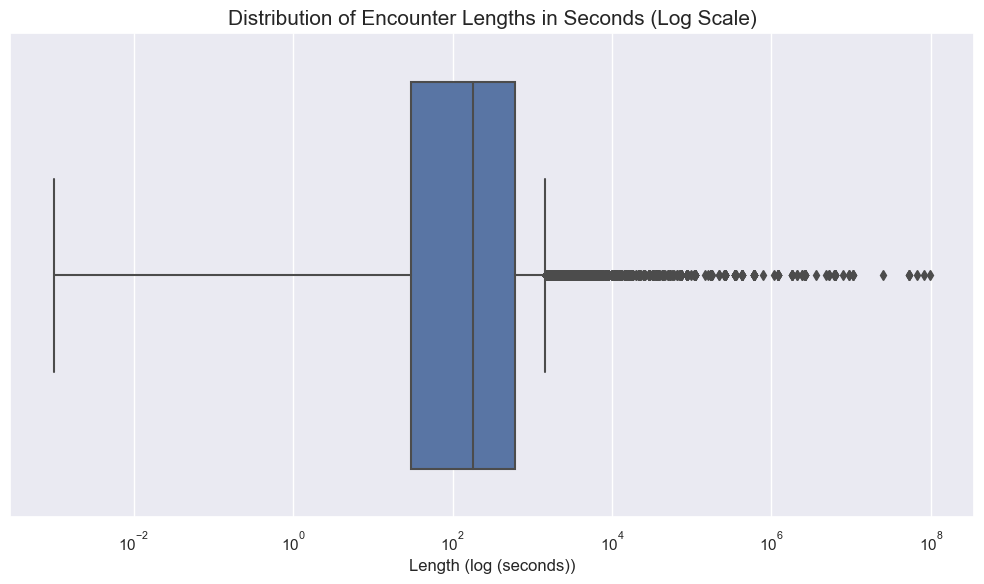

In [12]:
sns.set(rc={'figure.figsize':(10,6)})
sns.boxplot(x=ufo_df['length_of_encounter_seconds'])
plt.xscale('log')
plt.title('Distribution of Encounter Lengths in Seconds (Log Scale)', fontsize=15)
plt.xlabel('Length (log (seconds))')
plt.tight_layout()
plt.show()

**Summary:** Most of the encounter duration around are distributed around 10^1 to 10^3 in magnitude, either 10s of seconds or closer to an hour. There are many encounters past this mark which is pretty interesting considering anything greater in magnitude means encounters longer than a couple of hours. Either the person was subjected to a "supposed" abduction or the encounter duration recorded was a mistake.

**4) Encounter by Different Time Periods**

In [13]:
# Example with the standard date and time format
date_format = '%Y-%m-%d %H:%M:%S'

# converting string date time to date time type and then getting the day of the week
ufo_df['date_time_converted'] = ufo_df['Date_time'].apply(lambda x: datetime.strptime(x, date_format))
ufo_df['day'] = ufo_df['date_time_converted'].apply(lambda x: x.weekday())

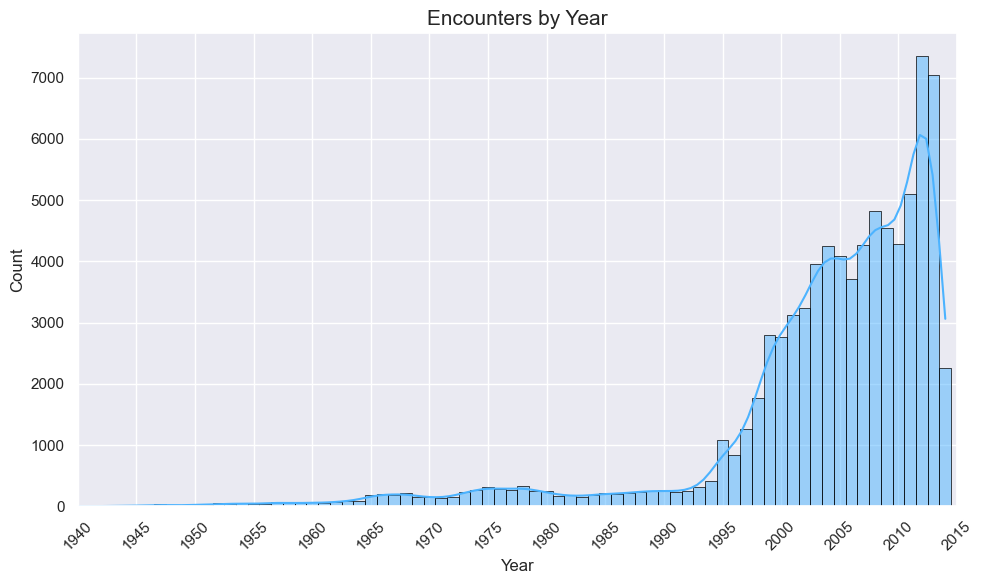

In [14]:
# top to bottom histograms of year, month, day, and hour encounters
a = plt.cm.cool
colors = [a(0.3),a(0.4),a(0.5), a(0.6)]

sns.set(rc={'figure.figsize':(10,6)})
sns.histplot(data=ufo_df, x="Year", kde=True, color = colors[0],
             edgecolor='black', linewidth=0.5, discrete=True)
plt.xticks(np.arange(1940, 2020, 5), rotation=45)
plt.xlim([1940, 2015])

plt.title('Encounters by Year', fontsize=15)
plt.tight_layout()
plt.show()

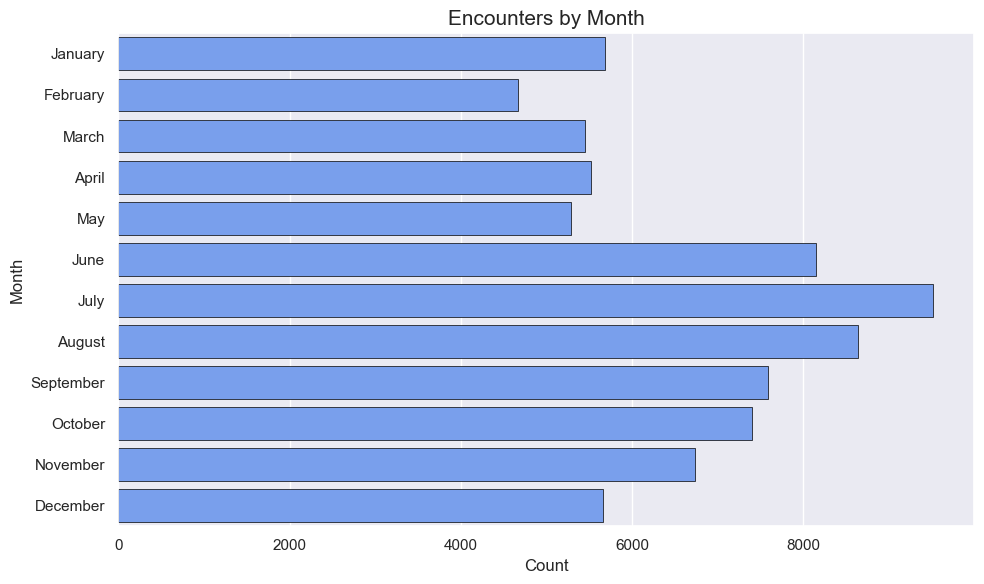

In [15]:
num_to_month = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June','7':'July','8':'August',
                '9':'September','10':'October','11':'November','12':'December'}

ufo_df['month_name'] = ufo_df['Month'].astype('str').replace(num_to_month)

month_count = ufo_df['month_name'].value_counts().reset_index()
month_count.columns = ['Month','Count']

sns.set(rc={'figure.figsize':(10,6)})
sns.barplot(data=month_count, x= 'Count', y="Month", color = colors[1],
             edgecolor='black', linewidth=0.5, order = list(num_to_month.values()))
plt.title('Encounters by Month', fontsize=15)
plt.tight_layout()
plt.show()

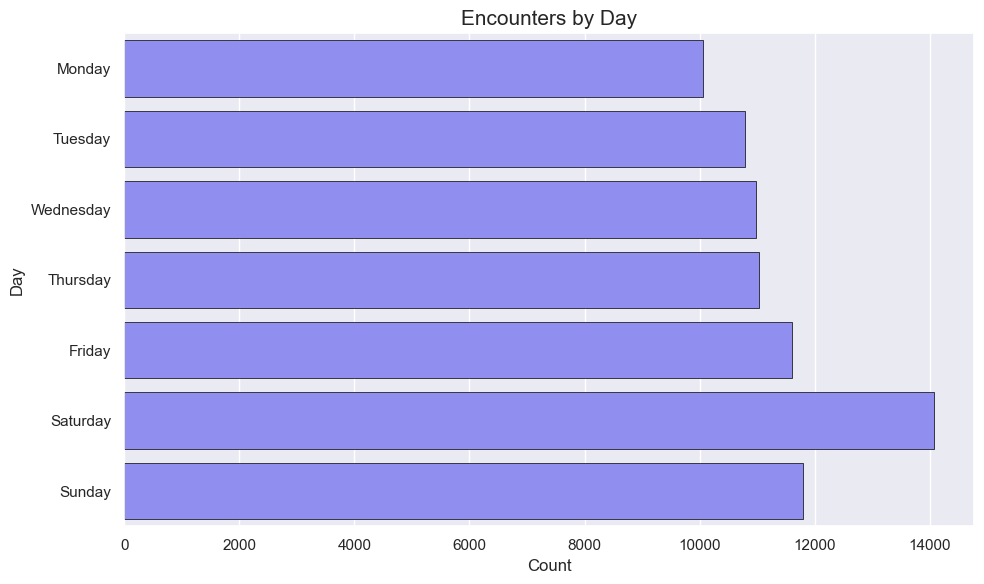

In [16]:
num_to_day = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}


ufo_df['day_name'] = ufo_df['day'].replace(num_to_day)

day_count = ufo_df['day_name'].value_counts().reset_index()
day_count.columns = ['Day','Count']

sns.set(rc={'figure.figsize':(10,6)})
sns.barplot(data=day_count, x="Count", y='Day', color = colors[2],
             edgecolor='black', linewidth=0.5, order = list(num_to_day.values()))
plt.title('Encounters by Day', fontsize=15)
plt.tight_layout()
plt.show()

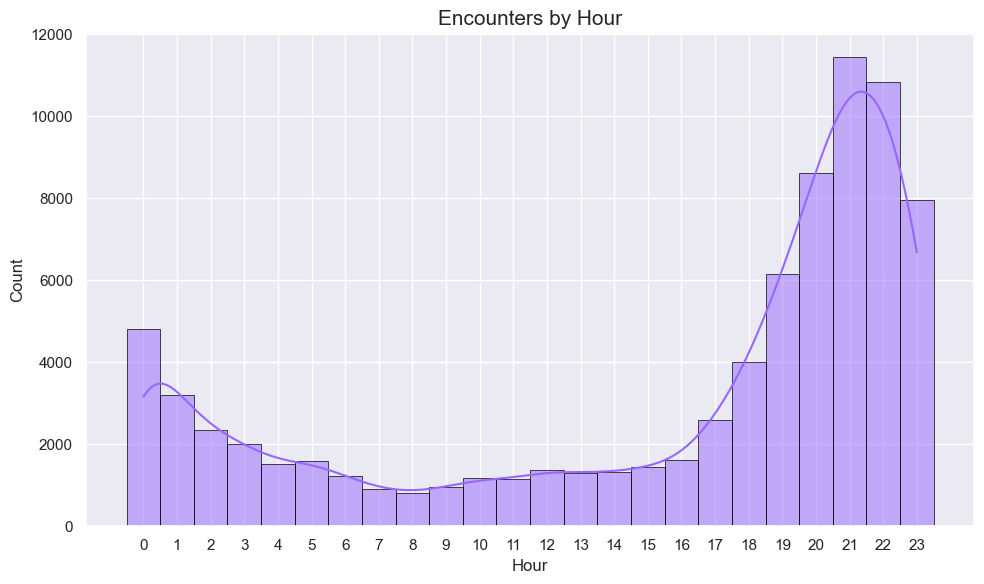

In [17]:
sns.set(rc={'figure.figsize':(10,6)})
sns.histplot(data=ufo_df, x="Hour", kde=True, color = colors[3],
             edgecolor='black', linewidth=0.5, discrete=True)
plt.xticks(np.arange(0, 24, 1))
plt.title('Encounters by Hour', fontsize=15)
plt.tight_layout()
plt.show()

**Summary:** Encounters are recorded closer to the 21st century which makes sense when comparing how digital records last over physical records. The summer months are the peak of encounters, with Saturdays having the largest set of data, and most happening in the late hours of the night, towards 2-3 AM. 

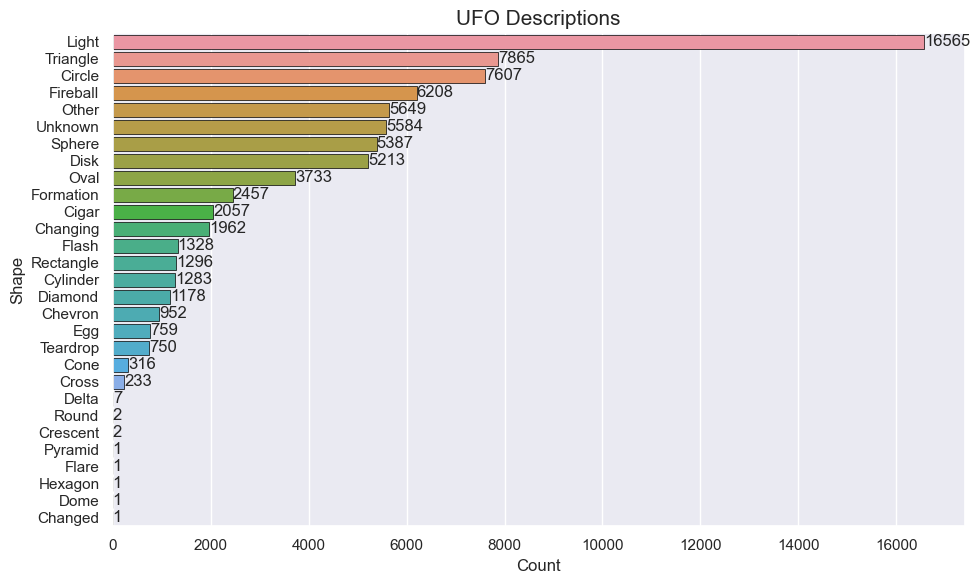

In [18]:
# bar chart chart of types of ufo_descriptions
shape_counts = ufo_df['UFO_shape'].value_counts().reset_index()
shape_counts.columns = ['Shape','Count']

sns.set(rc={'figure.figsize':(10,6)})

ax = sns.barplot(data=shape_counts, x= 'Count', y="Shape",
             edgecolor='black', linewidth=0.5)

ax.bar_label(ax.containers[0], label_type='edge')

plt.title('UFO Descriptions', fontsize=15)
plt.tight_layout()
plt.show()

**Summary:** The UFO descriptions that have the highest number are light, triangle, circle, fireball, and other. The original column was labeled shape so I'm not sure how "light" would be considered a shape. The other ones I would definitely consider to be shapes. The light is probably referring to the UFO encounter being seen as a pattern of light instead of a geometric shape.

## 2. Natural Language Processing

I would like to extract the most common features of UFO sightings and discuss possible phenomena regarding flight patterns and characteristics of the vehicles themselves. I could also explore the idea of sentiment analysis on the description, primarily whether the person was scared or not scared. 

Let's start with preprocessing the description column.

1. Lowercasing everything
2. Removing punctuation, special symbols
3. Removing words that are numbers and digits
4. Removing extra spaces
5. Removing stopwords
6. Lemmatizing

In [51]:
text_df = pd.DataFrame()
text_df['start'] = ufo_df['Description']
# drop missing
text_df = text_df.dropna()

text_df

start
0      This event took place in early fall around 194...
1      1949 Lackland AFB&#44 TX.  Lights racing acros...
2      Green/Orange circular disc over Chester&#44 En...
3      My older brother and twin sister were leaving ...
4      AS a Marine 1st Lt. flying an FJ4B fighter/att...
...                                                  ...
80323  Round from the distance/slowly changing colors...
80324  Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...
80325                                       Napa UFO&#44
80326  Saw a five gold lit cicular craft moving fastl...
80327  2 witnesses 2  miles apart&#44 Red &amp; White...

[80313 rows x 1 columns]

**1. Lowercase everything.**

In [52]:
text_df['lower'] = text_df['start'].apply(lambda x: x.lower())
text_df['lower']

0        this event took place in early fall around 194...
1        1949 lackland afb&#44 tx.  lights racing acros...
2        green/orange circular disc over chester&#44 en...
3        my older brother and twin sister were leaving ...
4        as a marine 1st lt. flying an fj4b fighter/att...
                               ...                        
80323    round from the distance/slowly changing colors...
80324    boise&#44 id&#44 spherical&#44 20 min&#44 10 r...
80325                                         napa ufo&#44
80326    saw a five gold lit cicular craft moving fastl...
80327    2 witnesses 2  miles apart&#44 red &amp; white...
Name: lower, Length: 80313, dtype: object

**2. Removing Punctuation/Special Symbols**

In [53]:
text_df['no_punc'] = text_df['lower'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
text_df['no_punc']

0        this event took place in early fall around 194...
1        1949 lackland afb  44 tx   lights racing acros...
2        green orange circular disc over chester  44 en...
3        my older brother and twin sister were leaving ...
4        as a marine 1st lt  flying an fj4b fighter att...
                               ...                        
80323    round from the distance slowly changing colors...
80324    boise  44 id  44 spherical  44 20 min  44 10 r...
80325                                         napa ufo  44
80326    saw a five gold lit cicular craft moving fastl...
80327    2 witnesses 2  miles apart  44 red  amp  white...
Name: no_punc, Length: 80313, dtype: object

**3. Removing numbers**

In [54]:
text_df['no_num'] = text_df['no_punc'].apply(lambda x: re.sub(r'[0-9]', ' ', x))
text_df['no_num']

0        this event took place in early fall around    ...
1             lackland afb     tx   lights racing acros...
2        green orange circular disc over chester     en...
3        my older brother and twin sister were leaving ...
4        as a marine  st lt  flying an fj b fighter att...
                               ...                        
80323    round from the distance slowly changing colors...
80324    boise     id     spherical        min        r...
80325                                         napa ufo    
80326    saw a five gold lit cicular craft moving fastl...
80327      witnesses    miles apart     red  amp  white...
Name: no_num, Length: 80313, dtype: object

**4. Remove extra spaces**

In [55]:
text_df['no_space'] = text_df['no_num'].apply(lambda x: re.sub(r' +', ' ', x))
text_df['no_space'] = text_df['no_space'].apply(lambda x: x.strip())
text_df['no_space']

0        this event took place in early fall around it ...
1        lackland afb tx lights racing across the sky a...
2          green orange circular disc over chester england
3        my older brother and twin sister were leaving ...
4        as a marine st lt flying an fj b fighter attac...
                               ...                        
80323    round from the distance slowly changing colors...
80324    boise id spherical min red lights seen by husb...
80325                                             napa ufo
80326    saw a five gold lit cicular craft moving fastl...
80327    witnesses miles apart red amp white elongated ...
Name: no_space, Length: 80313, dtype: object

In [10]:
text_df['no_space'][80325]

'napa ufo'

**5. Remove stop words**

In [56]:
#nltk.download('stopwords')
stop = stopwords.words('english')
text_df['no_stopwords'] = text_df['no_space'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
text_df['no_stopwords']

0        event took place early fall around occurred bo...
1        lackland afb tx lights racing across sky amp m...
2               green orange circular disc chester england
3        older brother twin sister leaving edna theater...
4        marine st lt flying fj b fighter attack aircra...
                               ...                        
80323       round distance slowly changing colors hovering
80324    boise id spherical min red lights seen husband...
80325                                             napa ufo
80326    saw five gold lit cicular craft moving fastly ...
80327    witnesses miles apart red amp white elongated ...
Name: no_stopwords, Length: 80313, dtype: object

**6. Lemmatization**

In [57]:
wnl = WordNetLemmatizer()

In [58]:
print('Before:',text_df['no_stopwords'][1])
print('After:', ' '.join([wnl.lemmatize(word) for word in text_df['no_stopwords'][1].split()]))

Before: lackland afb tx lights racing across sky amp making degree turns dime
After: lackland afb tx light racing across sky amp making degree turn dime


While the lemmetization doesn't do much in terms of making changes since most of the observations contain less sentence structure and more details and adjectives. However, it will allow for the count of words for using word clouds and other NLP processes to perform more smoothly. The tradeoff between lemmatization and stemming is that lemmatization looks for the best English translation for the words. With there being also many formatting errors and losing words due to it, unfortunately its the best we can work with for now.

In [59]:
text_df['lemmatize'] = text_df['no_stopwords'].apply(lambda x: ' '.join([wnl.lemmatize(word) for word in x.split()]))
text_df['lemmatize']

0        event took place early fall around occurred bo...
1        lackland afb tx light racing across sky amp ma...
2               green orange circular disc chester england
3        older brother twin sister leaving edna theater...
4        marine st lt flying fj b fighter attack aircra...
                               ...                        
80323        round distance slowly changing color hovering
80324    boise id spherical min red light seen husband ...
80325                                             napa ufo
80326    saw five gold lit cicular craft moving fastly ...
80327    witness mile apart red amp white elongated cig...
Name: lemmatize, Length: 80313, dtype: object

In [60]:
print('Overall Before:',text_df['start'][1])
print('Final Result:', text_df['lemmatize'][1])

Overall Before: 1949 Lackland AFB&#44 TX.  Lights racing across the sky &amp; making 90 degree turns on a dime.
Final Result: lackland afb tx light racing across sky amp making degree turn dime


### 1. Word Frequencies and Word Cloud
Now that all the preprocessing is finished, let's try some small-scale NLP projects and tasks. Starting with visualizing word frequencies and distributions in a word cloud.

In [15]:
res = text_df['lemmatize'].str.split(expand=True).stack().value_counts()
bag = res.rename_axis('unique_values').reset_index(name='counts')
# Display result
bag[:15]

unique_values  counts
0          light   36090
1         object   19186
2            sky   17582
3         bright   13358
4         moving    9266
5         orange    8953
6          white    8180
7            red    7963
8         shaped    7060
9            saw    6740
10         craft    5963
11           ufo    5779
12          seen    5748
13          like    5598
14        flying    5026

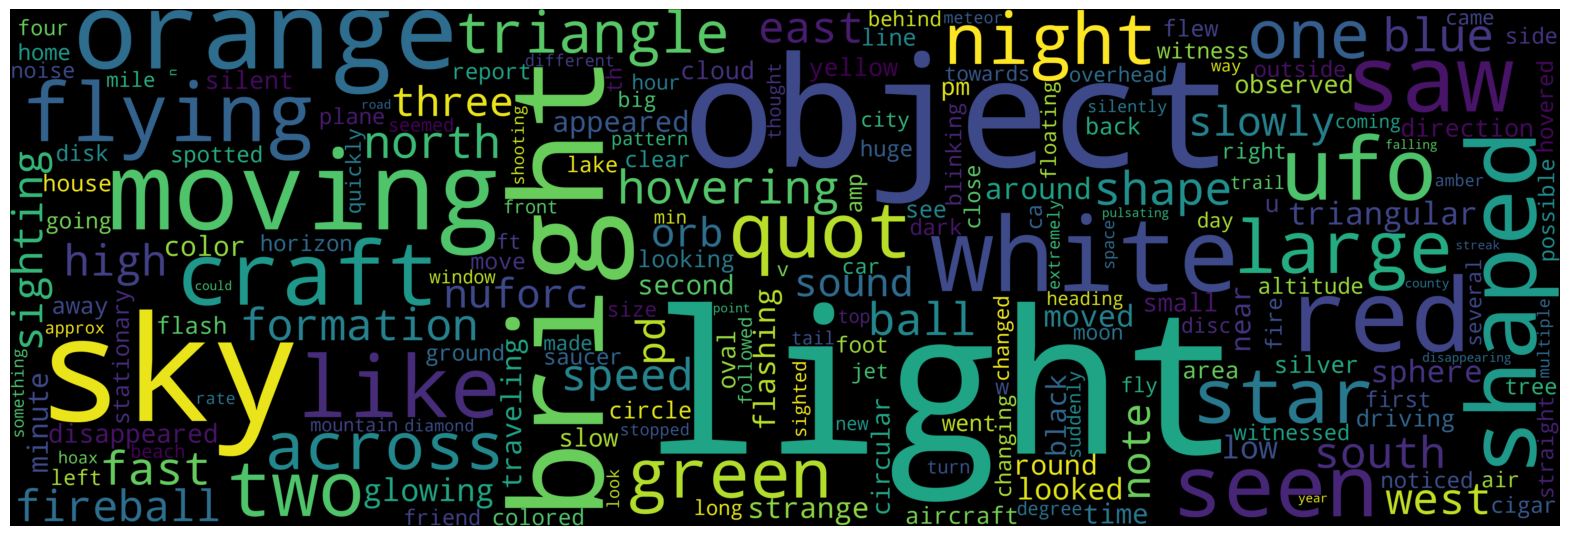

In [16]:
d = {}
for a, x in bag.values:
    d[a] = x

wordcloud = WordCloud(width=4800, height=1600)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Some of the most frequent words are descriptors of the UFO encounter, light, object, colors, and the method of movement. There are other frequent words also seen in the word cloud that are verbs and not descriptors as people have submitted their experiences through a first-person viewpoint. If we ignore those, there are some fascinating frequent words that appear as well. I would say the most interesting feature of the frequencies are the repeated use of orange, bright, and light. This could be a great indicator that encounters most likely involve some kind of bright light curiously of the color orange. While most film adaptations use the color green to indicate aliens and the presence of their crafts, in records from the public up to the present, they most observed are bright orange "light" vehicles.

### 2. Sentiment Analysis
Next: sentiment analysis! I think this could be an interesting study into how people feel about UFO encounters? Could they be positive or negative, or completely neutral without a fear?

In [68]:
text_df['sentiment'] = text_df['lemmatize'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [69]:
text_df

start  \
0      This event took place in early fall around 194...   
1      1949 Lackland AFB&#44 TX.  Lights racing acros...   
2      Green/Orange circular disc over Chester&#44 En...   
3      My older brother and twin sister were leaving ...   
4      AS a Marine 1st Lt. flying an FJ4B fighter/att...   
...                                                  ...   
80323  Round from the distance/slowly changing colors...   
80324  Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...   
80325                                       Napa UFO&#44   
80326  Saw a five gold lit cicular craft moving fastl...   
80327  2 witnesses 2  miles apart&#44 Red &amp; White...   

                                                   lower  \
0      this event took place in early fall around 194...   
1      1949 lackland afb&#44 tx.  lights racing acros...   
2      green/orange circular disc over chester&#44 en...   
3      my older brother and twin sister were leaving ...   
4      as a marine 1st lt. flying an fj4b fighter/att...   
...                                                  ...   
80323  round from the distance/slowly changing colors...   
80324  boise&#44 id&#44 spherical&#44 20 min&#44 10 r...   
80325                                       napa ufo&#44   
80326  saw a five gold lit cicular craft moving fastl...   
80327  2 witnesses 2  miles apart&#44 red &amp; white...   

                                                 no_punc  \
0      this event took place in early fall around 194...   
1      1949 lackland afb  44 tx   lights racing acros...   
2      green orange circular disc over chester  44 en...   
3      my older brother and twin sister were leaving ...   
4      as a marine 1st lt  flying an fj4b fighter att...   
...                                                  ...   
80323  round from the distance slowly changing colors...   
80324  boise  44 id  44 spherical  44 20 min  44 10 r...   
80325                                       napa ufo  44   
80326  saw a five gold lit cicular craft moving fastl...   
80327  2 witnesses 2  miles apart  44 red  amp  white...   

                                                  no_num  \
0      this event took place in early fall around    ...   
1           lackland afb     tx   lights racing acros...   
2      green orange circular disc over chester     en...   
3      my older brother and twin sister were leaving ...   
4      as a marine  st lt  flying an fj b fighter att...   
...                                                  ...   
80323  round from the distance slowly changing colors...   
80324  boise     id     spherical        min        r...   
80325                                       napa ufo       
80326  saw a five gold lit cicular craft moving fastl...   
80327    witnesses    miles apart     red  amp  white...   

                                                no_space  \
0      this event took place in early fall around it ...   
1      lackland afb tx lights racing across the sky a...   
2        green orange circular disc over chester england   
3      my older brother and twin sister were leaving ...   
4      as a marine st lt flying an fj b fighter attac...   
...                                                  ...   
80323  round from the distance slowly changing colors...   
80324  boise id spherical min red lights seen by husb...   
80325                                           napa ufo   
80326  saw a five gold lit cicular craft moving fastl...   
80327  witnesses miles apart red amp white elongated ...   

                                            no_stopwords  \
0      event took place early fall around occurred bo...   
1      lackland afb tx lights racing across sky amp m...   
2             green orange circular disc chester england   
3      older brother twin sister leaving edna theater...   
4      marine st lt flying fj b fighter attack aircra...   
...                                                  ...   
80323     round distance s

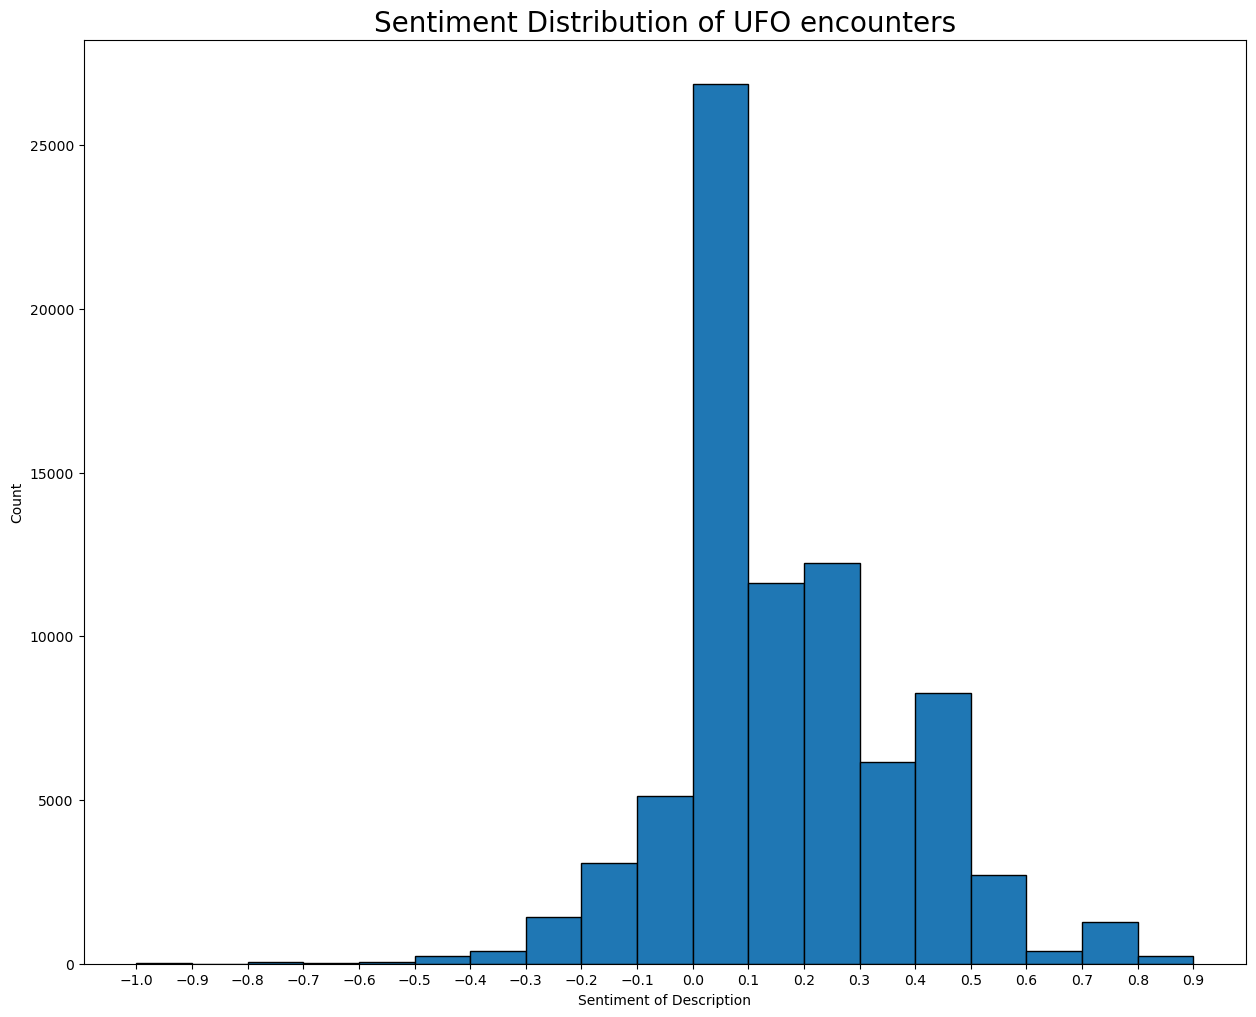

In [70]:
plt.figure(figsize=(15,12))
plt.hist(text_df['sentiment'], bins =np.arange(-1,1,.1), edgecolor = 'black')
plt.xticks(np.arange(-1,1,.1))
plt.xlabel('Sentiment of Description')
plt.ylabel('Count')
plt.title('Sentiment Distribution of UFO encounters', fontsize = 20)
plt.show()

As guessed previously, since most of the encounters are strictly details and statements, it would make sense that the peak of the sentiment distribution of the dataset to be closer to 0. However, the data seems to be tighter around the positive half of sentiment rather than the negative half. Does this imply that people feel positive about the encounters? That's hard to say. What we can surmise is that people will describe these encounters to the best of their ability and therefore have some sort of positive sentiment as recognized by the library. 

### 3. Text Generations

A final small-scale NLP project I wanted to try my hand at was performing text generations. I'm curious as with the bag of words from the entire data set if we are able to emulate and create "fake" encounter descriptions. Since I have used tensorflow/keras for previous machine learning projects, I will also use it here along with the LSTM network to try and create descriptions after feeding an initial frame and building about 10 15 words after.

Inspiration: 
1. https://spotintelligence.com/2022/12/19/text-generation-nlp/
2. https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/

I should probably start from the no_space column in the text_df to keep stopwords and valid sentence structure. Additionally I should try and remove words that have been cropped due to formatting error or mispelled. Using NLTK words I can remove abbreviations by performing a simple lambda operation.

In [62]:
# nltk.download('words')
words = set(nltk.corpus.words.words())

text_df['generations'] = text_df['no_space'].apply(lambda x : " ".join(w for w in wordpunct_tokenize(x) 
                                                                       if w.lower() in words or not w.isalpha()))

text_df['generations']

0        this event took place in early fall around it ...
1        lackland racing across the sky making degree t...
2                  green orange circular disc over chester
3        my older brother and twin sister were leaving ...
4        as a marine st flying an b fighter attack airc...
                               ...                        
80323    round from the distance slowly colors and hove...
80324        id spherical min red seen by husband and wife
80325                                                 napa
80326        saw a five gold lit craft moving from to left
80327    apart red white elongated cigar shaped flashin...
Name: generations, Length: 80313, dtype: object

In [63]:
print('Before:',text_df['no_space'][1])
print('After:', text_df['generations'][1])

Before: lackland afb tx lights racing across the sky amp making degree turns on a dime
After: lackland racing across the sky making degree turns on a dime


As seen above, using the words corpus from NLTK many of the non english words are removed, making it easier for the model to attempt and make english sentences. However, it doesn't clean up spelling errors in the example below.

In [64]:
print('Before:',text_df['no_space'][4])
print('After:', text_df['generations'][4])

Before: as a marine st lt flying an fj b fighter attack aircraft on a solo night exercise i was at in a quot clean quot aircraft no ordinan
After: as a marine st flying an b fighter attack aircraft on a solo night exercise i was at in a quot clean quot aircraft no


I think the word was supposed to be quote instead of quot, or the quot itself could be an error, but this is a situation where I am unsure of what it could mean. I will remove single letters .

In [65]:
ok_letters = ['a','i']
text_df['generations2'] = text_df['generations'].apply(lambda x: ' '.join([w for w in x.split() 
                                                                          if len(w)>1 or w in ok_letters] ))

In [66]:
print('Before:',text_df['generations'][4])
print('After:', text_df['generations2'][4])

Before: as a marine st flying an b fighter attack aircraft on a solo night exercise i was at in a quot clean quot aircraft no
After: as a marine st flying an fighter attack aircraft on a solo night exercise i was at in a quot clean quot aircraft no


In [67]:
print('Overall Before:',text_df['start'][1])
print('Final Result:', text_df['generations2'][1])

Overall Before: 1949 Lackland AFB&#44 TX.  Lights racing across the sky &amp; making 90 degree turns on a dime.
Final Result: lackland racing across the sky making degree turns on a dime


### 1. First Attempt
**LSTM Summary:** From doing some research, LSTM stands for Long Short-Term Memory which is a deep-learning recurrent neural network (RNN) which incorporates feedback connections, which are able to process sequences of data instead of just points. This is important for the task of text generation as the model should try to predict the word that comes next in a string based on it's predecessor. The LSTM has different components starting with a forget gate, input and new information gate, and the output gate. The forget gate takes the previous word or phrase into context and chooses whether it needs to use it in addition to the inputted words. The input and the new information gate takes the sentence fragment I start with and hte model considers whether it has anything new to add to the model. Based on previous iterations it may or may not use a similar response to a different starting sentence fragment. The output gate presents the result.

In [163]:
# tokenize the column
texts=' '.join(text_df['generations2'].tolist())
tokens = texts.split()

In [164]:
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

Total Tokens: 936593
Unique Tokens: 8895


In [165]:
# generating sequences of tokens by having 49 tokens plus an output token of 1, making a sequence of 50
length = 49 + 1
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 936543


In [166]:
# saving the sequence file
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    
out_filename = 'ufo_sequences.txt'
save_doc(sequences, out_filename)

In [3]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# load
in_filename = 'ufo_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

In [5]:
## tokenizing the sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

In [6]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

8894


In [71]:
# checking whether all sequences had the same length
#for i, lst in enumerate(sequences):
   # if len(lst) != 50:
       # print(i, len(lst),'\n')
        #print(lst, '\n')

The sequences weren't all the same size, so I have to pad them to the same length.

In [10]:
# padding sequences to have the same length (50)
padded_sequences = pad_sequences(sequences, maxlen=50, padding='pre')

In [11]:
from numpy import array

# placing the sequences into an array
array_sequences = array(padded_sequences)
# extracting x, and y where x is the sequence of 49 words, and y would be the predicted next word
X, y = array_sequences[:,:-1], array_sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
# setting a sequence length of 49
seq_length = X.shape[1]

In [12]:
print(X.shape, y.shape)
print(X[1],y[1])

(936543, 49) (936543, 8894)
[ 490  261  405    2  298  657   79   15  124    3 1229 2312 1664    2
    1 1285    1 1285 1509 5928 1456   46    1    7  259  349  383   17
    3 1199   40   19   93  183   11 1663   25 2657  549    4 1228  693
   45  358    1  253 2150   14   44] [0. 0. 0. ... 0. 0. 0.]


In [13]:
# simple LSTM model
model = Sequential()
model.add(Embedding(vocab_size, 49, input_length=seq_length))
model.add(LSTM(50))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 49, 49)            435806    
                                                                 
 lstm (LSTM)                 (None, 50)                20000     
                                                                 
 dense (Dense)               (None, 8894)              453594    
                                                                 
Total params: 909400 (3.47 MB)
Trainable params: 909400 (3.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, batch_size=128, epochs=10)

Epoch 1/10
7317/7317 [==============================] - 315s 43ms/step - loss: 5.4638 - accuracy: 0.1095
Epoch 2/10
7317/7317 [==============================] - 308s 42ms/step - loss: 4.8801 - accuracy: 0.1711
Epoch 3/10
7317/7317 [==============================] - 320s 44ms/step - loss: 4.7045 - accuracy: 0.1882
Epoch 4/10
7317/7317 [==============================] - 325s 44ms/step - loss: 4.6032 - accuracy: 0.1978
Epoch 5/10
7317/7317 [==============================] - 335s 46ms/step - loss: 4.5335 - accuracy: 0.2043
Epoch 6/10
7317/7317 [==============================] - 343s 47ms/step - loss: 4.4817 - accuracy: 0.2090
Epoch 7/10
7317/7317 [==============================] - 343s 47ms/step - loss: 4.4411 - accuracy: 0.2128
Epoch 8/10
7317/7317 [==============================] - 343s 47ms/step - loss: 4.4079 - accuracy: 0.2157
Epoch 9/10
7317/7317 [==============================] - 343s 47ms/step - loss: 4.3798 - accuracy: 0.2181
Epoch 10/10
7317/7317 [==============================] 

In [17]:
# save the model to file
model.save('model.h5')
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [18]:
# load cleaned text sequences
in_filename = 'ufo_sequences.txt'
doc = load_doc(in_filename)
# getting data to predict on
lines = doc.split('\n')

In [22]:
# setting a new sequence length to be 49 words so the model can predict the 50th
seq_length = len(lines[0].split()) - 1

# loading the model and the tokenizer created from before
model = load_model('model.h5')
tokenizer = load(open('tokenizer.pkl', 'rb'))

In [45]:
# getting a random sequence from the text to be used to predict from
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')

appear in the sky rotating and i saw an object that closely a star shoot across the sky extremely fast witness large slow moving craft at drive in driving home at night i by a flying vehicle in my lane of traffic football shaped on one end flying saucer with



In [46]:
# generate the sequence
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        #print(encoded)
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        
        predict_x=model.predict(encoded, verbose=0) 
        classes_x=np.argmax(predict_x,axis=1)
        #print(classes_x)
        
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == classes_x:
                out_word = word
                break
            # append to input
        in_text += ' ' + out_word
        result.append(out_word)
            
    return ' '.join(result)

generated = generate_seq(model, tokenizer, seq_length, seed_text, 49)
print(generated)

red and blue and white light in the middle of the sky in the sky in the sky it was a bright light in the sky it was a bright light in the sky it was a bright light in the sky it was a bright light in the


**Summary so far:** The sequencing function makes sense, but there are some factors to consider as well as code to fix before the text generator becomes much more effective. For example, training the model on 10 epochs took around an hour. That is a pretty long time, and since I don't think the model had begun to overfit, there is still much more time I could let it train before running the generation again. The generated sequence itself has a coherent structure at the beginning but it devolved into repetition near the end. This is most likely due to the insufficient training time for the model. It isn't able to pick up on patterns past the 20% accuracy it currently has. This will be worked on in the following milestone. But temporarily it will have to do for the submission. For example, when the model sees the string in the sky, it immediately starts using the pattern of it was a bright light in the sky. Which is unfortunate but reasonable since most encounters would probably start with that string or have something along the lines of that.

The next step would be to look at some preliminary time-series analysis. Since the text generation is taking up so much more time, I might end up dropping the time-series portion of the project since the data doesn't have any time-series data apart from the timestamp of the data. If I were to perform analysis, it would be something along the lines of predicting the number of encounters using the date-time column grouped by season, month, and maybe day to run some ARIMA and SARIMA. I also might end up using data only from the 21st century as most of the sightings have been reported since the digitization and availability of posting these encounters.
**___________________________________________________________________________________________________________________________**

### 2. Second Attempt
I will try to shorten the sequences as well as only pick strings of a length longer than 20 words. That way when I do generate sequences, they will be of 20 words like a typical encounter description. First I have to reclean the text data because I forgot to save it, and then generate a new sequences txt file with 20 words instead of 50.

In [13]:
# recleaning data for next steps
def get_clean_text():
    text_df = pd.DataFrame()
    text_df['start'] = ufo_df['Description']
    # drop missing
    text_df = text_df.dropna()
    
    # lower case
    text_df['lower'] = text_df['start'].apply(lambda x: x.lower())
    
    # no punc
    text_df['no_punc'] = text_df['lower'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    
    # no number
    text_df['no_num'] = text_df['no_punc'].apply(lambda x: re.sub(r'[0-9]', ' ', x))
    
    # no space
    text_df['no_space'] = text_df['no_num'].apply(lambda x: re.sub(r' +', ' ', x))
    text_df['no_space'] = text_df['no_space'].apply(lambda x: x.strip())
    
    # all english words
    words = set(nltk.corpus.words.words())

    text_df['generations'] = text_df['no_space'].apply(lambda x : " ".join(w for w in wordpunct_tokenize(x) 
                                                                           if w.lower() in words or not w.isalpha()))
    # remove single characters except a and i
    ok_letters = ['a','i']
    text_df['generations2'] = text_df['generations'].apply(lambda x: ' '.join([w for w in x.split() 
                                                                               if len(w)>1 or w in ok_letters] ))
    print('Overall Before:',text_df['start'][1])
    print('Final Result:', text_df['generations2'][1])
    
    text_df.to_csv('encounter_descriptions_clean.csv')
    return text_df

In [14]:
#get_clean_text()

Overall Before: 1949 Lackland AFB&#44 TX.  Lights racing across the sky &amp; making 90 degree turns on a dime.
Final Result: lackland racing across the sky making degree turns on a dime


start  \
0      This event took place in early fall around 194...   
1      1949 Lackland AFB&#44 TX.  Lights racing acros...   
2      Green/Orange circular disc over Chester&#44 En...   
3      My older brother and twin sister were leaving ...   
4      AS a Marine 1st Lt. flying an FJ4B fighter/att...   
...                                                  ...   
80323  Round from the distance/slowly changing colors...   
80324  Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...   
80325                                       Napa UFO&#44   
80326  Saw a five gold lit cicular craft moving fastl...   
80327  2 witnesses 2  miles apart&#44 Red &amp; White...   

                                                   lower  \
0      this event took place in early fall around 194...   
1      1949 lackland afb&#44 tx.  lights racing acros...   
2      green/orange circular disc over chester&#44 en...   
3      my older brother and twin sister were leaving ...   
4      as a marine 1st lt. flying an fj4b fighter/att...   
...                                                  ...   
80323  round from the distance/slowly changing colors...   
80324  boise&#44 id&#44 spherical&#44 20 min&#44 10 r...   
80325                                       napa ufo&#44   
80326  saw a five gold lit cicular craft moving fastl...   
80327  2 witnesses 2  miles apart&#44 red &amp; white...   

                                                 no_punc  \
0      this event took place in early fall around 194...   
1      1949 lackland afb  44 tx   lights racing acros...   
2      green orange circular disc over chester  44 en...   
3      my older brother and twin sister were leaving ...   
4      as a marine 1st lt  flying an fj4b fighter att...   
...                                                  ...   
80323  round from the distance slowly changing colors...   
80324  boise  44 id  44 spherical  44 20 min  44 10 r...   
80325                                       napa ufo  44   
80326  saw a five gold lit cicular craft moving fastl...   
80327  2 witnesses 2  miles apart  44 red  amp  white...   

                                                  no_num  \
0      this event took place in early fall around    ...   
1           lackland afb     tx   lights racing acros...   
2      green orange circular disc over chester     en...   
3      my older brother and twin sister were leaving ...   
4      as a marine  st lt  flying an fj b fighter att...   
...                                                  ...   
80323  round from the distance slowly changing colors...   
80324  boise     id     spherical        min        r...   
80325                                       napa ufo       
80326  saw a five gold lit cicular craft moving fastl...   
80327    witnesses    miles apart     red  amp  white...   

                                                no_space  \
0      this event took place in early fall around it ...   
1      lackland afb tx lights racing across the sky a...   
2        green orange circular disc over chester england   
3      my older brother and twin sister were leaving ...   
4      as a marine st lt flying an fj b fighter attac...   
...                                                  ...   
80323  round from the distance slowly changing colors...   
80324  boise id spherical min red lights seen by husb...   
80325                                           napa ufo   
80326  saw a five gold lit cicular craft moving fastl...   
80327  witnesses miles apart red amp white elongated ...   

                                             generations  \
0      this event took place in early fall around it ...   
1      lackland racing across the sky making degree t...   
2                green orange circular disc over chester   
3      my older brother and twin sister were leaving ...   
4      as a marine st flying an b fighter attack airc...   
...                                                  ...   
80323  round from the dist

In [31]:
# loading for next milestones
text_df = pd.read_csv('encounter_descriptions_clean.csv')
text_df = text_df.dropna()

In [57]:
# tokenize and save sequences
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text


def get_sequences_file(seq_length):
    encounters_list = text_df['generations2'].tolist()
    # choosing text descriptions greater than a number of words
    long_descriptions= [x for x in encounters_list if len(x.split()) > seq_length]
    print('The number of descriptions with',seq_length,'words is',len(long_descriptions),'.')
    
    # get tokens
    texts=' '.join(long_descriptions)
    tokens = texts.split()
    print('Total Tokens: %d' % len(tokens))
    print('Unique Tokens: %d' % len(set(tokens)))
    
    # generating sequences of 
    length = seq_length
    sequences = list()
    for i in range(length, len(tokens)):
        # select sequence of tokens
        seq = tokens[i-length:i]
        # convert into a line
        line = ' '.join(seq)
        # store
        sequences.append(line)
    print('Total Sequences: %d' % len(sequences))
    
    # saving file
    out_filename = 'ufo_sequences_shorter.txt'
    save_doc(sequences, out_filename)
    
    return seq_length

In [95]:
seq_length = get_sequences_file(25)

# load
in_filename = 'ufo_sequences_shorter.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

The number of descriptions with 25 words is 2104 .
Total Tokens: 57099
Unique Tokens: 2544
Total Sequences: 57074


A significant decrease in the number of sequences and unique tokens, should require less memory and less training time. But I can adjust the sequence length as needed.

In [96]:
def tokenize_sequences(seq_length):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    sequences = tokenizer.texts_to_sequences(lines)
    vocab_size = len(tokenizer.word_index) + 1
    print('Vocab Size:', vocab_size)
    
    # padding sequences to ensure the data is passed through correctly
    padded_sequences = pad_sequences(sequences, maxlen=seq_length, padding='pre')
    
    # placing the sequences into an array
    array_sequences = np.array(padded_sequences)
    # extracting x, and y where x is the sequence of 49 words, and y would be the predicted next word
    X, y = array_sequences[:,:-1], array_sequences[:,-1]
    y = to_categorical(y, num_classes=vocab_size)
    # setting a sequence length of 49
    X_sequence = X.shape[1]
    
    print('X Shape:',X.shape, '| Y Shape:',y.shape)
    #print(X[1],y[1])
    print('Data Loaded!')
    
    return X, y, X_sequence, vocab_size, tokenizer

In [97]:
X, y, X_sequence, vocab_size, tokenizer_saved = tokenize_sequences(seq_length)

Vocab Size: 2545
X Shape: (57074, 24) | Y Shape: (57074, 2545)
Data Loaded!


In [125]:
# X Sequence is the input length and the seq_length was the length of sequences chosen earlier on
# X sequence is always going to be one less than seq_length since x sequence is the input length for the x arrays

def firstmodel(X, y, X_sequence, vocab_size, seq_length):
    print('For text descriptions of length:', X_sequence)
    
    # Define the model
    model = Sequential()
    model.add(Embedding(vocab_size, seq_length-1, input_length=X_sequence))
    model.add(LSTM(50))
    model.add(Dense(vocab_size, activation='softmax'))
    print(model.summary())
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit model
    model.fit(X, y, batch_size=128, epochs=100)
    
    return model

def secondmodel(X, y, X_sequence, vocab_size, seq_length):
    print('For text descriptions of length:', X_sequence)
    
    # Define the model
    model = Sequential()
    model.add(Embedding(vocab_size, seq_length-1, input_length=X_sequence))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))
    print(model.summary())
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit model
    model.fit(X, y, batch_size=128, epochs=100)
    
    return model

In [109]:
model1 = firstmodel(X, y, X_sequence, vocab_size, seq_length)

For text descriptions of length: 24
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 24, 24)            61080     
                                                                 
 lstm_4 (LSTM)               (None, 50)                15000     
                                                                 
 dense_4 (Dense)             (None, 2545)              129795    
                                                                 
Total params: 205875 (804.20 KB)
Trainable params: 205875 (804.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
446/446 [==============================] - 8s 14ms/step - loss: 5.6068 - accuracy: 0.0580
Epoch 2/100
446/446 [==============================] - 6s 14ms/step - loss: 5.2656 - accuracy: 0.0633
Epoch 3/100
446/446 [============

In [154]:
model1.evaluate(X, y)

1784/1784 [==============================] - 6s 3ms/step - loss: 2.7195 - accuracy: 0.3938


[2.71954345703125, 0.393839567899704]

Minimizing the cell output to save space on the pdf.

In [149]:
model2 = secondmodel(X, y, X_sequence, vocab_size, seq_length)

For text descriptions of length: 24
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 24, 24)            61080     
                                                                 
 lstm_9 (LSTM)               (None, 24, 100)           50000     
                                                                 
 lstm_10 (LSTM)              (None, 100)               80400     
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 2545)              257045    
                                                                 
Total params: 458625 (1.75 MB)
Trainable params: 458625 (1.75 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________

In [155]:
model2.evaluate(X, y)

1784/1784 [==============================] - 14s 8ms/step - loss: 1.8596 - accuracy: 0.5246


[1.8595939874649048, 0.5246171355247498]

In [158]:
model2.save('model2.h5')

In [159]:
from pickle import dump
dump(tokenizer_saved, open('tokenizer.pkl', 'wb'))

Increasing the depth of the LSTM model increased the accuracy of the model by around 13% in this current iteration. I think with more experimentation, the accuracy can be increased further, but for now I will use it to generate text.

In [173]:
# setting a new sequence length to be 19 words so the model can predict the 20th
# seq_length = len(lines[0].split()) - 1

# select a seed text
from random import randint

# getting a random sequence from the text to be used to predict from
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')

i was in my back yard the dogs when i a loud low rumble of a passing jet plane when i up i saw a



In [174]:
# generate the sequence
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        #print(encoded)
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length-1, truncating='pre')
        # predict probabilities for each word
        
        predict_x=model.predict(encoded, verbose=0) 
        classes_x=np.argmax(predict_x,axis=1)
        #print(classes_x)
        
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == classes_x:
                out_word = word
                break
            # append to input
        in_text += ' ' + out_word
        result.append(out_word)
            
    return ' '.join(result)

# first model
generated = generate_seq(model1, tokenizer_saved, seq_length, seed_text, 25)
# second model
generated2 = generate_seq(model2, tokenizer_saved, seq_length, seed_text, 25)

In [175]:
print('Seed:',seed_text,'\n')
print('Generated:',generated,'\n')
print('Together:',seed_text,'',generated)

Seed: i was in my back yard the dogs when i a loud low rumble of a passing jet plane when i up i saw a 

Generated: light in the sky it was a bright light in the sky i was driving home from work and i was looking at the sky 

Together: i was in my back yard the dogs when i a loud low rumble of a passing jet plane when i up i saw a  light in the sky it was a bright light in the sky i was driving home from work and i was looking at the sky


In [176]:
print('Seed:',seed_text,'\n')
print('Generated:',generated2,'\n')
print('Together:',seed_text,'',generated2)

Seed: i was in my back yard the dogs when i a loud low rumble of a passing jet plane when i up i saw a 

Generated: bright light in the sky it was moving very fast like a star or a drone but it was moving in a downward slant i 

Together: i was in my back yard the dogs when i a loud low rumble of a passing jet plane when i up i saw a  bright light in the sky it was moving very fast like a star or a drone but it was moving in a downward slant i


**Conclusion of NLP Section** The second model generated more sophisticated sentences than the first. The first model with the generalized layers and without depth started to gravitate towards common patterns in the sequences (looking up at the sky and seeing a bright light). The second model was able to avoid that and have a subject about seeing a bright light moving fast with a specific shape and a direction.

But evidently, increasing training epochs and decreasing the sequence length while considering the length of each of the encounter descriptions from the data frame was beneficial. The generations of the second model are a lot more promising than the first. With more tweaking and computing power, I don't doubt that the text generation model could create some very interesting generated UFO encounter descriptions.

## 3. Time Series Analysis

The last portion of the project will be performing some preliminary time series analysis. First I will have to engineer a time-series data section from the original data frame using the time-series column and grouping them by season, month, day, and hour. I think the day and hour will be much more intensive, so I will start with months. If I have time, I will attempt the seasons.

**1. Grouped by Month/Year**

In [458]:
# converting string date time to date time type and then getting the day of the week
b = pd.DataFrame()
b['date_time'] = pd.to_datetime(ufo_df['Date_time'],format='%Y-%m-%d %H:%M:%S')
b_grouped = b['date_time'].groupby(b['date_time'].dt.to_period("M")).agg('count')
#b_grouped = b_grouped.resample("M").count()
b_grouped_df = b_grouped.to_frame()

mask = (b_grouped_df.index > '1949-12') & (b_grouped_df.index <= '2014-05')

# select only encounters in mask
b_grouped_df = b_grouped_df.loc[mask]
b_grouped_df.columns = ['count']
b_grouped_df

count
date_time       
1950-01        1
1950-04        2
1950-06       14
1950-07        6
1950-08        2
...          ...
2014-01      643
2014-02      481
2014-03      442
2014-04      573
2014-05      121

[737 rows x 1 columns]

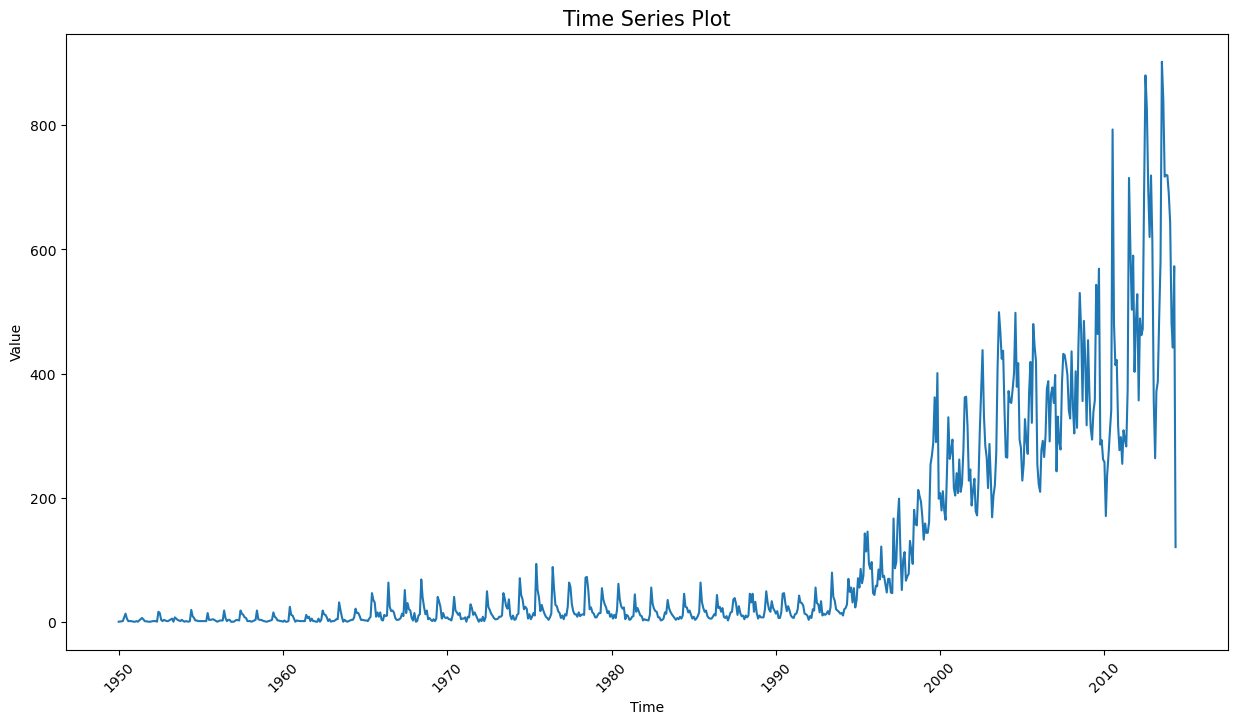

In [586]:
plt.figure(figsize=(15,8))
plt.plot(b_grouped_df.index.to_timestamp(), b_grouped_df['count'], linestyle = 'solid')

# Add title and axis labels

plt.title('Time Series Plot', fontsize=15)
plt.xlabel('Time')
plt.ylabel('Value')
plt.xticks(rotation=45)

# Display the plot
plt.show()

I could split the data into two sets. One from the 1950 till around 1995 and study it as a small nonstationary time series, and the data after 1995 can be studied as a trendy nonstationary time series since it also displays a trend. To prove that the data is nonstationary I will perform a dickey-fuller significance test.

In [277]:
index = b_grouped_df.reset_index()
index

date_time  count
0     1950-01      1
1     1950-04      2
2     1950-06     14
3     1950-07      6
4     1950-08      2
..        ...    ...
732   2014-01    643
733   2014-02    481
734   2014-03    442
735   2014-04    573
736   2014-05    121

[737 rows x 2 columns]

In [459]:
print(index[index['date_time']=='1995-12'].index)

# small nonstationary
nonstationary1 = b_grouped_df[:516]

# big nonstationary
nonstationary2 = b_grouped_df[516:]

print('Pre 1995 Nonstationary Dimensions:',len(nonstationary1),'| Post 1995 Nonstationary:',len(nonstationary2))

Index([515], dtype='int64')
Pre 1995 Nonstationary Dimensions: 516 | Post 1995 Nonstationary: 221


In [363]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(nonstationary1['count'])
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: 1.2747827354771164
ADF p-values: 0.9964639420725043
ADF number of lags used: 16
ADF number of observations: 499
ADF critical values: {'1%': -3.4435228622952065, '5%': -2.867349510566146, '10%': -2.569864247011056}
ADF best information criterion: 3630.4116154187896


The null hypothesis of the ADF test is that a unit root is present in the time series. The alternative hypothesis is that the data is stationary.

If I set a level of significance to be 0.05, we see that the p-value is much greater. In this case, we cannot reject the null hypothesis and will have to assume that the data is non-stationary. The data doesn't show it but it could have a very small trend.

In [364]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(nonstationary2['count'])
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -0.992134318117819
ADF p-values: 0.7561223060474613
ADF number of lags used: 13
ADF number of observations: 207
ADF critical values: {'1%': -3.4623415245233145, '5%': -2.875606128263243, '10%': -2.574267439846904}
ADF best information criterion: 2384.133990086026


If I set a level of significance to be 0.05, we see that the p-value is much greater. In this case, we cannot reject the null hypothesis and will have to assume that the data is non-stationary. This trend is visible in the graph.

### Pre 1995:

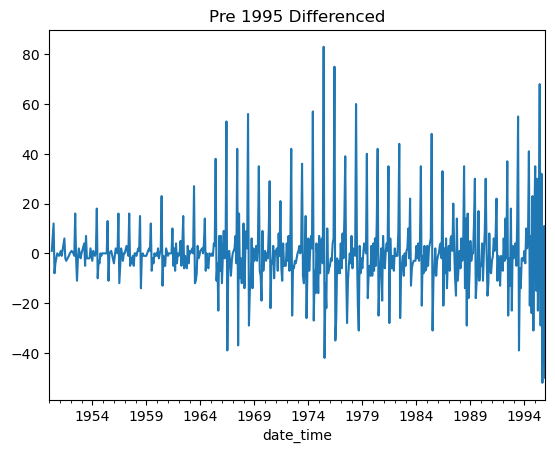

In [365]:
prev_sales_value1 = nonstationary1['count'].shift()
differenced_sales1 = nonstationary1['count'] - prev_sales_value1
differenced_sales1.plot()
plt.title('Pre 1995 Differenced')
plt.show()

In [374]:
# getting a df without index and index for splitting
diff_df1 = differenced_sales1.to_frame().fillna(method='bfill')

In [569]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(diff_df1['count'])
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -2.734786149853701
ADF p-values: 0.06820974352881061
ADF number of lags used: 16
ADF number of observations: 499
ADF critical values: {'1%': -3.4435228622952065, '5%': -2.867349510566146, '10%': -2.569864247011056}
ADF best information criterion: 3630.0905331660015


Using the dickey fuller test with significance level of 0.05, after differencing once, the data is close to being stationary (0.06 is the p value). So the arima model order we should use is (0,1,0). I will now create a rolling ARIMA model that takes in points every iteration the model is created to make the predictions as accurate as possible.

In [596]:
# split into train and test sets
X = nonstationary1.values
size = int(len(nonstationary1) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

In [597]:
predictions = []
residuals = []
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat) 
    obs = test[t]
    residual = yhat-obs
    residuals.append(residual)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))

Test RMSE: 16.872


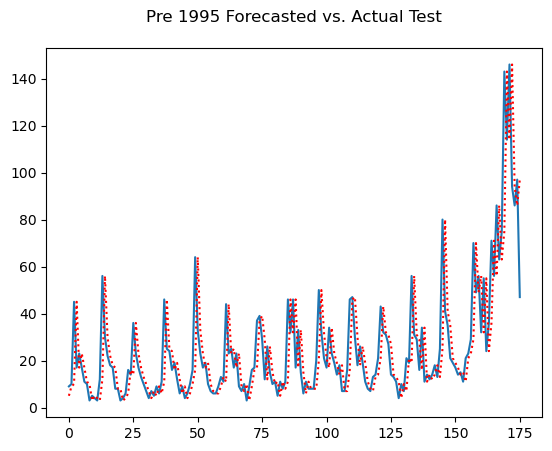

In [598]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red', linestyle='dotted')
plt.title('Pre 1995 Forecasted vs. Actual Test\n')
plt.show()

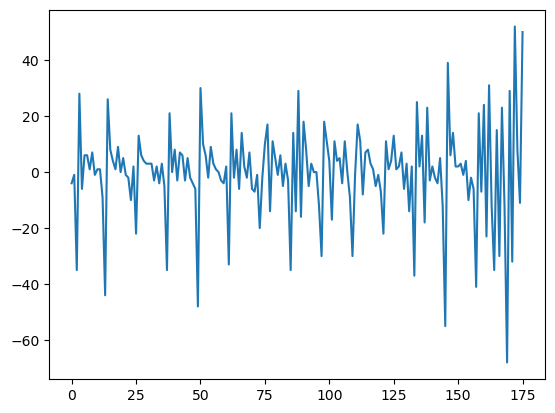

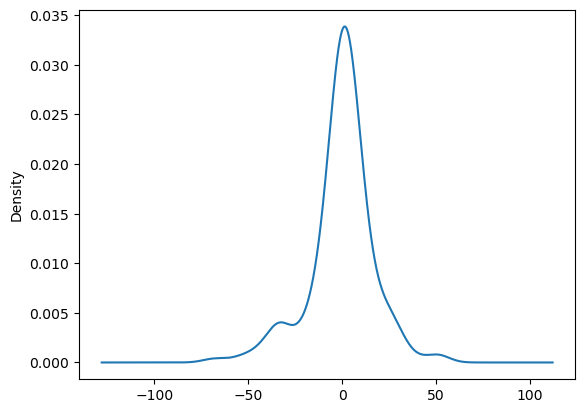

_______________________________
Summary Statistics of Residuals
_______________________________
count    176.000000
mean      -0.238636
std       16.895642
min      -68.000000
25%       -5.250000
50%        1.000000
75%        7.000000
max       52.000000
dtype: float64


In [599]:
residuals = [int(x) for x in residuals]
residuals_series = pd.Series(residuals)
residuals_series.plot()
plt.show()
# density plot of residuals
residuals_series.plot(kind='kde')
plt.show()
# summary stats of residuals
print('_______________________________')
print('Summary Statistics of Residuals')
print('_______________________________')
print(residuals_series.describe())

The residuals mean is close to 0 meaning that there is little to no bias in the data, and the model performed adequately well.

In [600]:
train_lst = [int(x) for x in train]
train_predictions = pd.Series(train_lst+predictions)

In [601]:
complete_df = pd.DataFrame()
complete_df['time']= nonstationary1.index.to_timestamp()
complete_df['train+predicted'] = train_predictions
complete_df_noidx = complete_df.set_index('time')
complete_df_noidx

train+predicted
time                       
1950-01-01              1.0
1950-04-01              2.0
1950-06-01             14.0
1950-07-01              6.0
1950-08-01              2.0
...                     ...
1995-08-01            114.0
1995-09-01            146.0
1995-10-01             94.0
1995-11-01             86.0
1995-12-01             97.0

[516 rows x 1 columns]

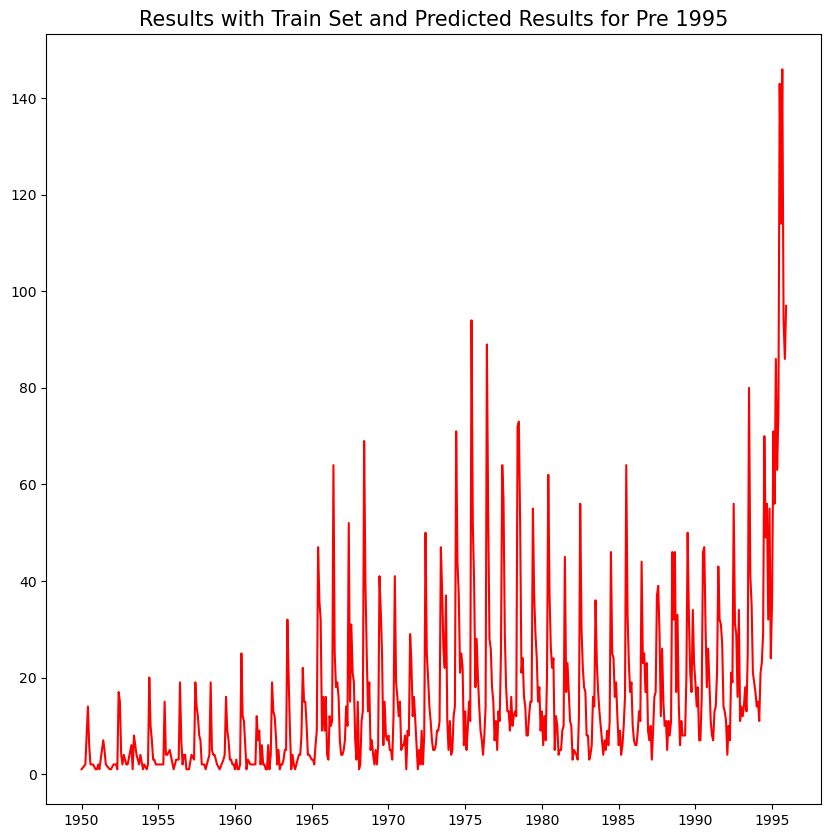

In [602]:
plt.figure(figsize=(10,10))
plt.plot(complete_df_noidx,color='red')
plt.title('Results with Train Set and Predicted Results for Pre 1995', fontsize=15)
plt.show()

### Post 1995

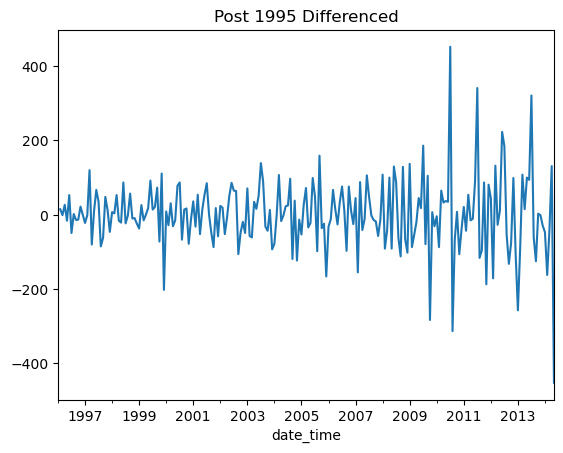

In [603]:
prev_sales_value2 = nonstationary2['count'].shift()
differenced_sales2 = nonstationary2['count'] - prev_sales_value2
differenced_sales2.plot()
plt.title('Post 1995 Differenced')
plt.show()

In [604]:
# getting a df without index and index for splitting
diff_df2 = differenced_sales2.to_frame().fillna(method='bfill')
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(diff_df2['count'])
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -5.79037385580092
ADF p-values: 4.888181494452253e-07
ADF number of lags used: 12
ADF number of observations: 208
ADF critical values: {'1%': -3.4621857592784546, '5%': -2.875537986778846, '10%': -2.574231080806213}
ADF best information criterion: 2383.0139299955795


Using the dickey fuller test with significance level of 0.05, after differencing once, the data is close to being stationary. So the arima model order we should use is (0,1,0). I will now create a rolling ARIMA model that takes in points every iteration the model is created to make the predictions as accurate as possible.

In [605]:
# split into train and test sets
X = nonstationary2.values
size = int(len(nonstationary2) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

In [606]:
predictions = []
residuals = []
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat) 
    obs = test[t]
    residual = yhat-obs
    residuals.append(residual)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))

Test RMSE: 138.712


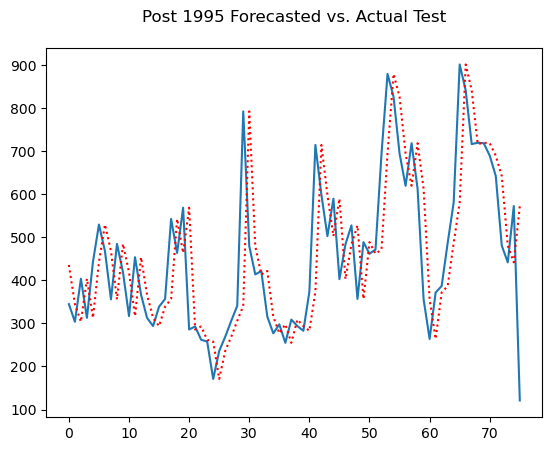

In [611]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.title('Post 1995 Forecasted vs. Actual Test\n')
plt.plot(predictions, color='red', linestyle='dotted')
plt.show()

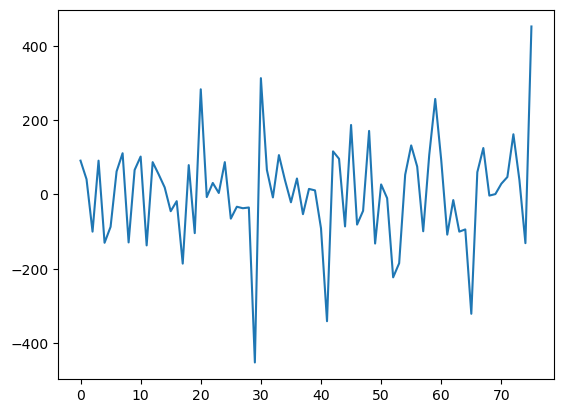

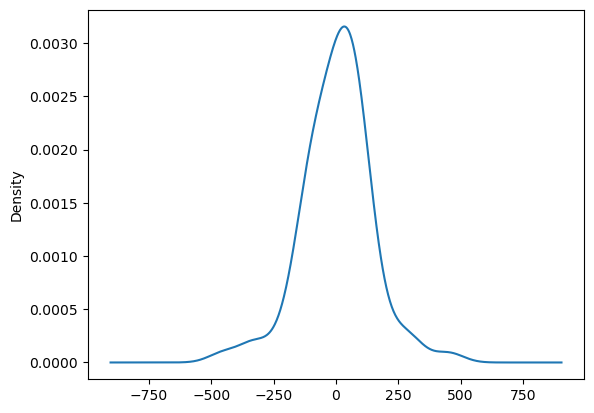

_______________________________
Summary Statistics of Residuals
_______________________________
count     76.000000
mean       4.171053
std      139.536986
min     -452.000000
25%      -86.250000
50%       13.000000
75%       87.000000
max      452.000000
dtype: float64


In [608]:
residuals = [int(x) for x in residuals]
residuals_series = pd.Series(residuals)
residuals_series.plot()
plt.show()
# density plot of residuals
residuals_series.plot(kind='kde')
plt.show()
# summary stats of residuals
print('_______________________________')
print('Summary Statistics of Residuals')
print('_______________________________')
print(residuals_series.describe())

The mean is slightly above 0, so the data may have bias, but not too much.

In [609]:
train_lst = [int(x) for x in train]
train_predictions = pd.Series(train_lst+predictions)

complete_df = pd.DataFrame()
complete_df['time']= nonstationary2.index.to_timestamp()
complete_df['train+predicted'] = train_predictions
complete_df_noidx = complete_df.set_index('time')
complete_df_noidx

train+predicted
time                       
1996-01-01             44.0
1996-02-01             59.0
1996-03-01             58.0
1996-04-01             85.0
1996-05-01             69.0
...                     ...
2014-01-01            690.0
2014-02-01            643.0
2014-03-01            481.0
2014-04-01            442.0
2014-05-01            573.0

[221 rows x 1 columns]

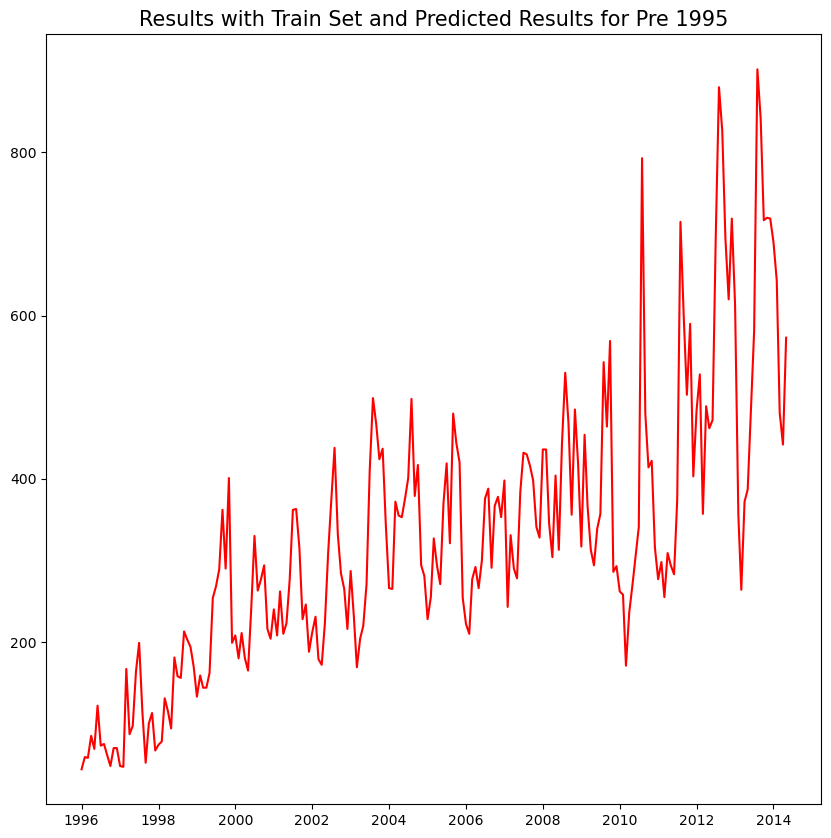

In [610]:
plt.figure(figsize=(10,10))
plt.plot(complete_df_noidx,color='red')
plt.title('Results with Train Set and Predicted Results for Pre 1995', fontsize=15)
plt.show()

**Conclusion:** For the time series portion of the project there was many things I didn't know how to do initially so I had to research many concepts such as the usage of ARIMA, figuring out the model parameters for the data after understanding stationarity was important. I had to walk through the process of figuring out the differences to determine the order shortly after. Both subsets of data only had to have one set of difference before becoming stationary as evident by the dickey-fuller test. I was then able to plot the predictions against hte test data and also decided on using a rolling ARIMA rather than the typical one. 

I still don't have a full understanding of what time series model works best and how to optimally fit the order and other hyperparameters as it has heavy statistical implications. Under the time constraints of this project, this was the best I could do at the moment. As mentioned before, I would be completely fine working on this outside of the class and on my own time as a passion project. 